In [11]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import ViTFeatureExtractor, ViTModel

In [7]:
# ------------------ FILTER & ALIGN -------------------
# 1) find segmented image basenames
segmented_files = [
    f for f in os.listdir(segmented_dir)
    if f.lower().endswith(('.jpg','jpeg','png'))
]
segmented_basenames = {os.path.splitext(f)[0] for f in segmented_files}

# 2) build map of all label files by basename
label_map = {
    os.path.splitext(fn)[0]: os.path.join(full_label_dir, fn)
    for fn in os.listdir(full_label_dir)
    if fn.endswith('.txt')
}

# 3) align images ⇄ labels
image_files = []
label_paths = []
for fn in sorted(segmented_files):
    base = os.path.splitext(fn)[0]
    if base in label_map:
        image_files.append(os.path.join(segmented_dir, fn))
        label_paths.append(label_map[base])
    else:
        print(f"[WARN] Skipping '{fn}' (no matching label)")

assert image_files, "No segmented images found or no matching labels!"


In [8]:
# ------------------ LOAD & PROCESS LABELS ------------
def load_first_label(txt_path):
    with open(txt_path, 'r') as f:
        line = f.readline().strip()
    return int(float(line.split()[0]))  # class 0–5

labels = [load_first_label(p) for p in label_paths]
labels_tensor = torch.tensor(labels, dtype=torch.long, device=device)
print("→ labels_tensor:", labels_tensor.shape, labels_tensor.dtype)

# -------------- EXTRACT ViT FEATURES ------------
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model         = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)
vit_model.eval()

# collect pixel batches
pixel_values = []
for img_path in image_files:
    img = Image.open(img_path).convert('RGB')
    enc = feature_extractor(images=img, return_tensors='pt')
    pixel_values.append(enc['pixel_values'])
pixel_values = torch.cat(pixel_values, dim=0).to(device)  # (N,3,224,224)
print("→ pixel_values:", pixel_values.shape)

# forward once
with torch.no_grad():
    outputs = vit_model(pixel_values=pixel_values)
embeddings = outputs.pooler_output  # (N,768)
print("→ embeddings:", embeddings.shape)


→ labels_tensor: torch.Size([375]) torch.int64


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


→ pixel_values: torch.Size([375, 3, 224, 224])
→ embeddings: torch.Size([375, 768])


In [4]:
# -------------- PREPARE IMAGES & EXTRACT FEATURES ------
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model         = ViTModel.from_pretrained("google/vit-base-patch16-224")
vit_model.eval()

image_files = sorted(
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith(("jpg","jpeg","png"))
)

pixel_values = []
for img_path in image_files:
    img = Image.open(img_path).convert("RGB")
    enc = feature_extractor(images=img, return_tensors="pt")
    pixel_values.append(enc["pixel_values"])
pixel_values = torch.cat(pixel_values, dim=0).to(device)  # (N,3,224,224)

with torch.no_grad():
    outputs = vit_model(pixel_values=pixel_values)
embeddings = outputs.pooler_output  # (N,768)

print("embeddings shape:", embeddings.shape)

labels_tensor shape: torch.Size([375]) | dtype: torch.int64


In [9]:
# -------------- DATASET & DATALOADER -----------
dataset  = TensorDataset(embeddings, labels_tensor)
loader   = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------- DEFINE & TRAIN MLP CLASSIFIER -----------
class MLP(nn.Module):
    def __init__(self, input_dim=768, num_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Linear(512,       256), nn.ReLU(),
            nn.Linear(256,       128), nn.ReLU(),
            nn.Linear(128,        64), nn.ReLU(),
            nn.Linear(64,     num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Starting training…")
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)                  # (B,6)
        loss   = criterion(logits, y_batch)      # CrossEntropy
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += y_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    print(f"Epoch {epoch}/{num_epochs}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

Starting training…
Epoch 1/100: loss=1.2555, acc=0.5947
Epoch 2/100: loss=0.7336, acc=0.7227
Epoch 3/100: loss=0.5885, acc=0.7440
Epoch 4/100: loss=0.4975, acc=0.7653
Epoch 5/100: loss=0.4517, acc=0.8107
Epoch 6/100: loss=0.3924, acc=0.8373
Epoch 7/100: loss=0.3357, acc=0.8800
Epoch 8/100: loss=0.2825, acc=0.8987
Epoch 9/100: loss=0.2506, acc=0.9013
Epoch 10/100: loss=0.2195, acc=0.9067
Epoch 11/100: loss=0.2750, acc=0.9040
Epoch 12/100: loss=0.2475, acc=0.9040
Epoch 13/100: loss=0.1963, acc=0.9173
Epoch 14/100: loss=0.1754, acc=0.9333
Epoch 15/100: loss=0.1514, acc=0.9360
Epoch 16/100: loss=0.1189, acc=0.9573
Epoch 17/100: loss=0.1053, acc=0.9680
Epoch 18/100: loss=0.0823, acc=0.9627
Epoch 19/100: loss=0.0701, acc=0.9760
Epoch 20/100: loss=0.0707, acc=0.9707
Epoch 21/100: loss=0.0439, acc=0.9867
Epoch 22/100: loss=0.0571, acc=0.9760
Epoch 23/100: loss=0.0488, acc=0.9787
Epoch 24/100: loss=0.0179, acc=0.9973
Epoch 25/100: loss=0.0124, acc=1.0000
Epoch 26/100: loss=0.0121, acc=1.0000
Ep

# **Testing**

In [13]:
# --------------- CONFIG -------------------
# Validation image & label directories
val_image_dir = '/kaggle/input/original-dataset/tongue_dataset/valid/images'
val_label_dir = '/kaggle/input/original-dataset/tongue_dataset/valid/labels'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -------------- ALIGN IMAGES ↔ LABELS -------
# 1) list image basenames
val_images = [f for f in os.listdir(val_image_dir)
              if f.lower().endswith(('.jpg','jpeg','png'))]
val_basenames = {os.path.splitext(f)[0] for f in val_images}

# 2) map all label files
label_map = {
    os.path.splitext(fn)[0]: os.path.join(val_label_dir, fn)
    for fn in os.listdir(val_label_dir) if fn.endswith('.txt')
}

In [14]:
# -------------- ALIGN IMAGES ↔ LABELS -------
# 1) list image basenames
val_images = [f for f in os.listdir(val_image_dir)
              if f.lower().endswith(('.jpg','jpeg','png'))]
val_basenames = {os.path.splitext(f)[0] for f in val_images}

# 2) map all label files
label_map = {
    os.path.splitext(fn)[0]: os.path.join(val_label_dir, fn)
    for fn in os.listdir(val_label_dir) if fn.endswith('.txt')
}

# 3) build aligned lists
image_paths = []
label_vals  = []
for img_fn in sorted(val_images):
    base = os.path.splitext(img_fn)[0]
    if base in label_map:
        image_paths.append(os.path.join(val_image_dir, img_fn))
        # load only the first value (class 0–5)
        with open(label_map[base],'r') as f:
            label_vals.append(int(float(f.readline().split()[0])))
    else:
        print(f"[WARN] No label for {img_fn}, skipping")

assert image_paths, "No validation images found!"

y_true = np.array(label_vals, dtype=int)


In [15]:
# -------------- EXTRACT ViT FEATURES ---------
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model         = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)
vit_model.eval()

pixel_values = []
for p in image_paths:
    img = Image.open(p).convert('RGB')
    enc = feature_extractor(images=img, return_tensors='pt')
    pixel_values.append(enc['pixel_values'])
pixel_values = torch.cat(pixel_values, dim=0).to(device)  # (M,3,224,224)

with torch.no_grad():
    vit_out = vit_model(pixel_values=pixel_values)
embeddings = vit_out.pooler_output  # (M,768)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Accuracy: 0.7857

Classification Report:
               precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         4
           3     0.5000    0.2500    0.3333         4
           5     0.8421    0.9412    0.8889        34

    accuracy                         0.7857        42
   macro avg     0.4474    0.3971    0.4074        42
weighted avg     0.7293    0.7857    0.7513        42



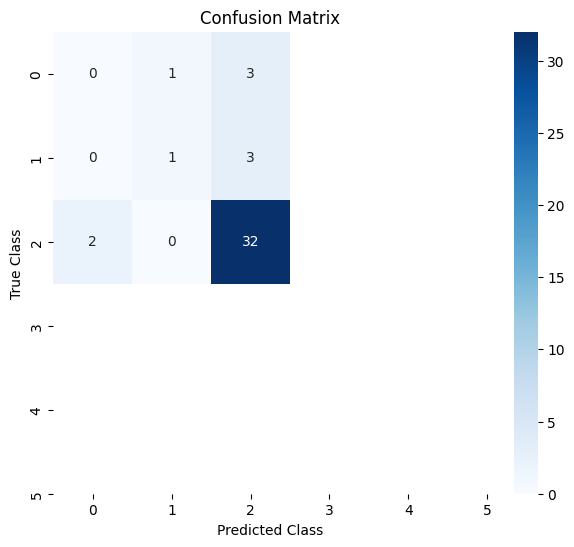

In [16]:
# -------------- RUN CLASSIFIER -----------------
model.eval()    # your trained MLP
with torch.no_grad():
    logits = model(embeddings)                # (M,6)
    preds  = torch.argmax(logits, dim=1).cpu().numpy()

# -------------- METRICS & REPORT -------------
acc    = accuracy_score(y_true, preds)
cm     = confusion_matrix(y_true, preds)
report = classification_report(y_true, preds, digits=4)

print(f"Overall Accuracy: {acc:.4f}\n")
print("Classification Report:\n", report)

# -------------- PLOT CONFUSION MATRIX -------
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(6), yticklabels=range(6))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()